In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation
%matplotlib ipympl
import numpy as np
import pandas as pd

from scipy.spatial import KDTree, cKDTree
from scipy.ndimage import uniform_filter1d
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

import time
import joblib
from tqdm import tqdm
import trackpy as tp
from numba import njit, prange

from yupi import Trajectory
import yupi.graphics as yg
import yupi.stats as ys

from utility import get_imsd, get_imsd_windowed, get_emsd, get_emsd_windowed, fit_hist, MB_2D,\
                    normal_distr, lorentzian_distr, get_trajs, speed_windowed, theta_windowed, \
                    get_smooth_trajs, get_velocities

In [3]:
traj_verb = "hough"

if traj_verb == "trackpy": 
    rawTrajs = pd.read_parquet("../tracking/results/tracking_data/trackpy_pre_merge.parquet")
    nDrops = int(len(rawTrajs.loc[rawTrajs.frame==0]))
    # Trajectory Smoothing: using a Savgol Filter in order to drop the noise due to the tracking procedure
    smoothTrajs = get_smooth_trajs(rawTrajs, nDrops, 30, 2)

    res_path = "results"
    analysis_data_path = "analysis_data"

elif traj_verb == "hough":
    rawTrajs = pd.read_parquet("../tracking/results/tracking_data//hough/linked_pre_merge.parquet")#pd.read_parquet("../tracking/results/tracking_data/tracking_hough_trackpy_linking.parquet")
    nDrops = int(len(rawTrajs.loc[rawTrajs.frame==0]))
    # Trajectory Smoothing: using a Savgol Filter in order to drop the noise due to the tracking procedure
    smoothTrajs = get_smooth_trajs(rawTrajs, nDrops, 30, 2)

    res_path = "hough_results"
    analysis_data_path = "hough_analysis_data"
else:
    raise ValueError("traj_verb must be either 'trackpy' or 'hough'")

red_particle_idx = 17
colors = rawTrajs.loc[rawTrajs.frame == 0, 'color'].values
nFrames = int(max(rawTrajs.frame) + 1)
fps = 10
print(f"Number of Droplets: {nDrops}")
print(f"Number of Frames: {nFrames} at {fps} fps --> {nFrames/10:.2f} s")

# WINDOWED ANALYSIS PARAMETERS
window = 3200 # 320 s
stride = 100 # 10 s
print("Windowed analysis args:")

startFrames = np.arange(0, nFrames-window, stride, dtype=int)
endFrames = startFrames + window
nSteps = len(startFrames)
print(f"window of {window/10} s, stride of {stride/10} s --> {nSteps} steps")

# step 10 with a 10 fps video --> 1 s
units = "px/s"
default_kwargs_blue = {"color": "#00FFFF", "ec": (0, 0, 0, 0.6), "density": True}
default_kwargs_red = {"color": "#EE4B2B", "ec": (0, 0, 0, 0.6), "density": True}

Number of Droplets: 50
Number of Frames: 32269 at 10 fps --> 3226.90 s
Windowed analysis args:
window of 320.0 s, stride of 10.0 s --> 291 steps


# MSD

MSD Analysis: trajs_verb = hough, show_verb = True, run_windowed_analysis = True, animated_plot_verb = True
Global IMSD


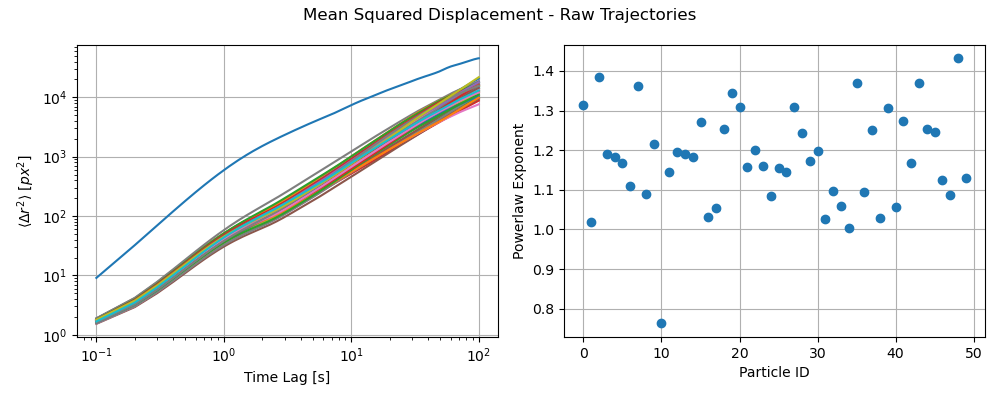

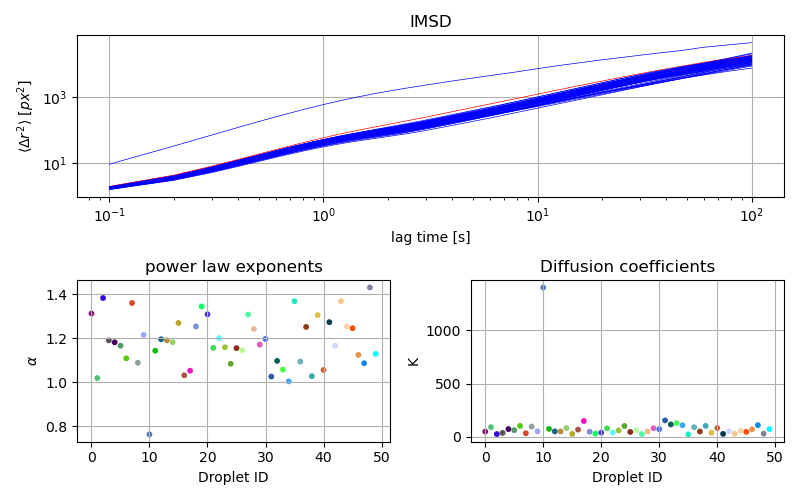

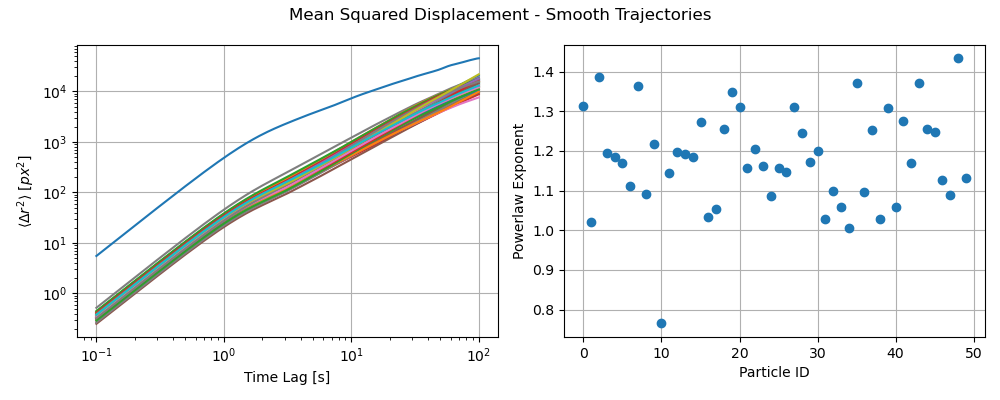

Global EMSD
Raw trajs - Blue Particles: a = 1.154 ± 0.001, K = 73.727 ± 0.464
Raw trajs - Red Particle: a = 1.053 ± 0.003, K = 148.56 ± 1.821
Smooth trajs - Blue Particles: a = 1.156 ± 0.001, K = 73.096 ± 0.469
Smooth trajs - Red Particle: a = 1.054 ± 0.003, K = 147.74 ± 1.823


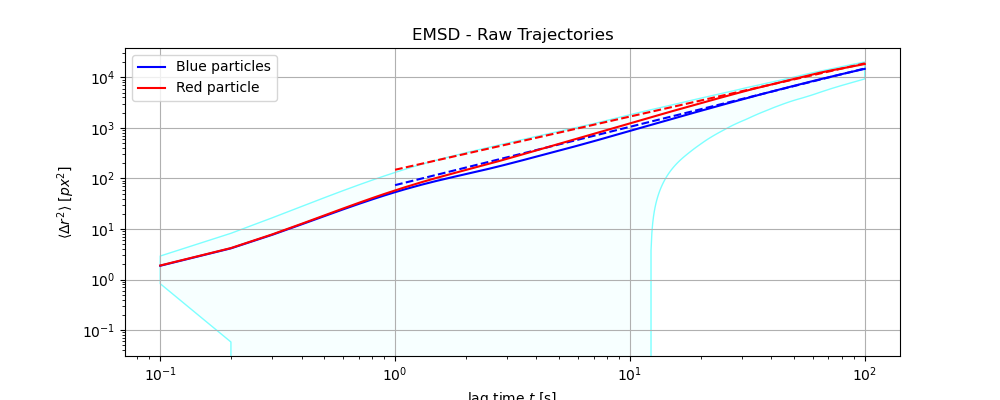

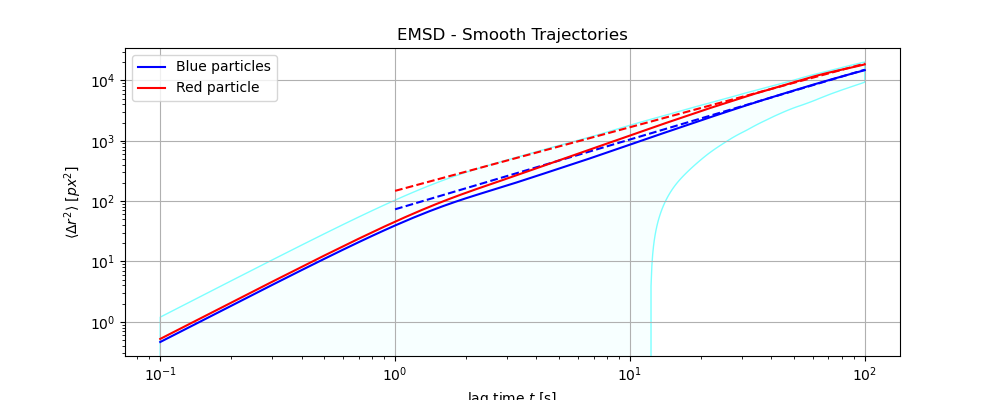

Windowed IMSD


100%|██████████| 291/291 [06:26<00:00,  1.33s/it]


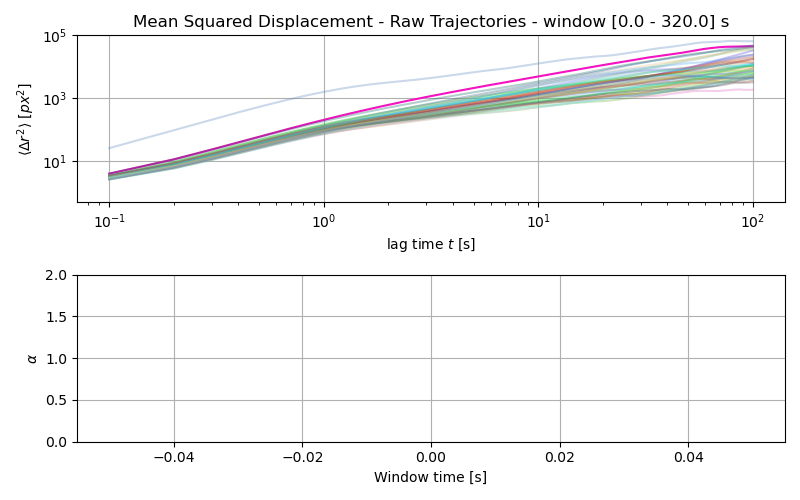

/Users/matteoscandola/miniconda3/envs/pyenv3/lib/python3.10/site-packages/matplotlib/animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


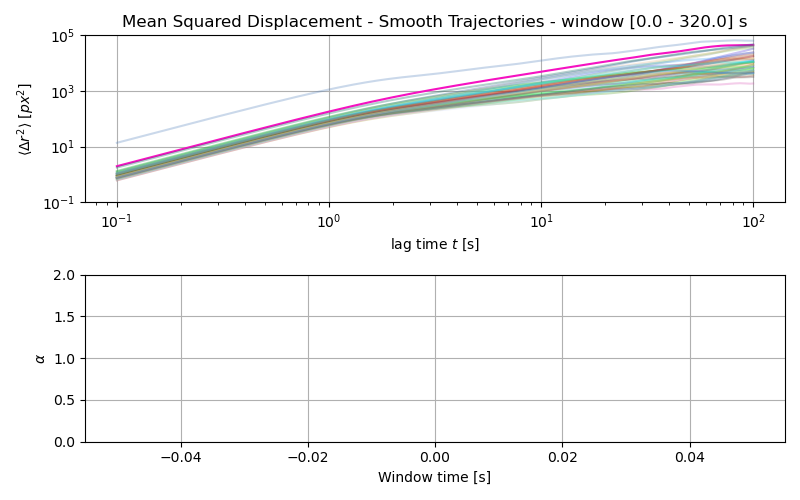

Windowed EMSD


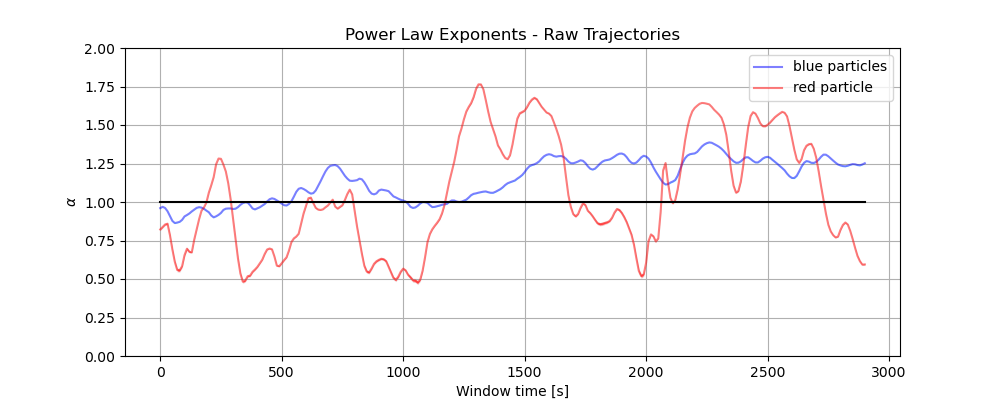

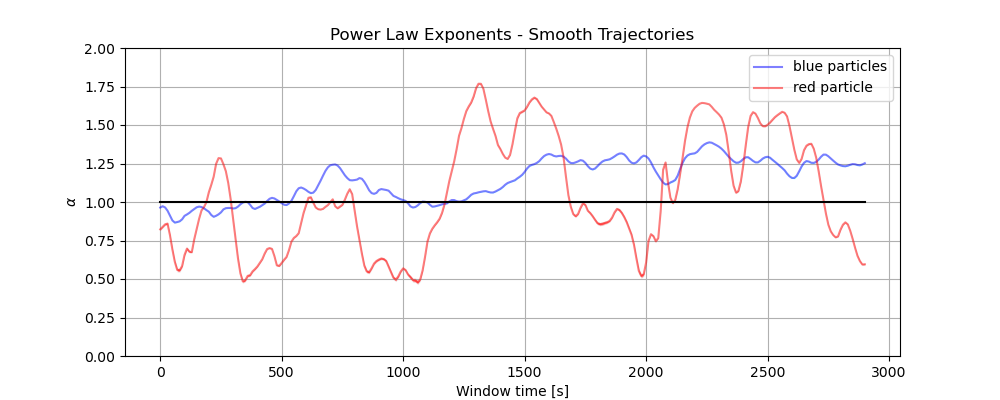

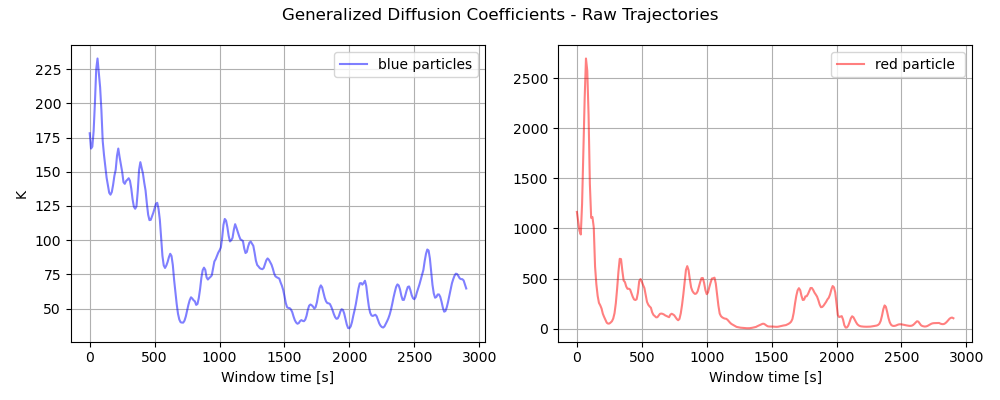

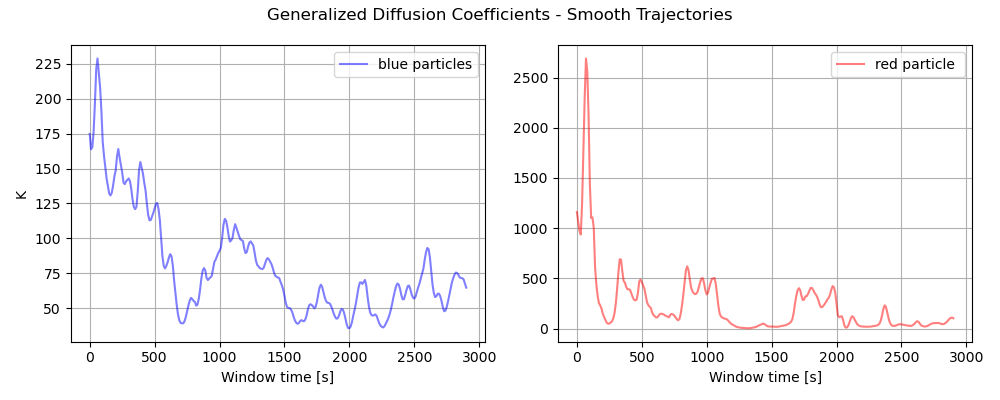

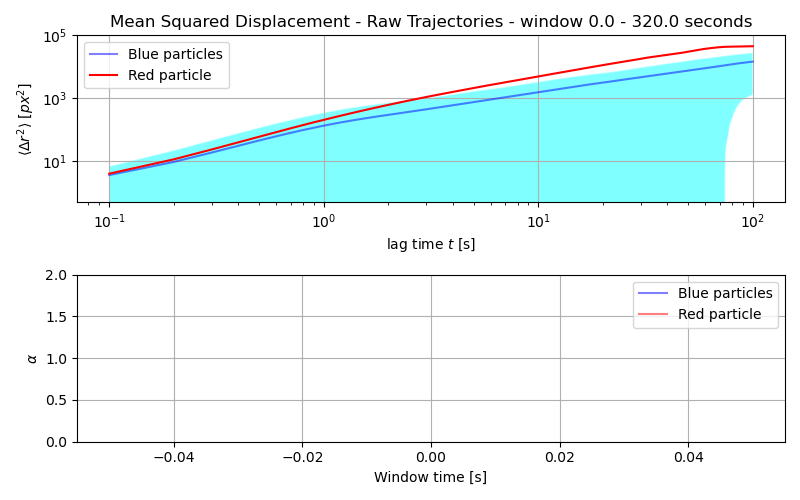

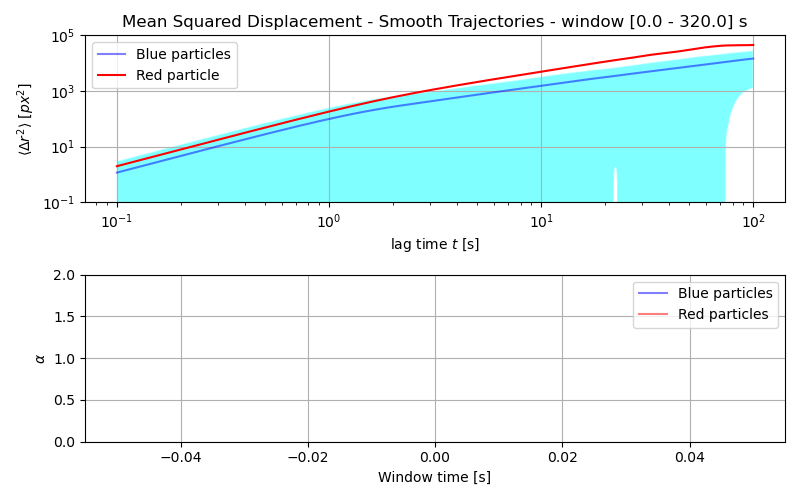

In [4]:
show_verb = True
run_windowed_analysis = True
plot_verb = True
animated_plot_verb = True
save_verb = False

print(f"MSD Analysis: trajs_verb = {traj_verb}, show_verb = {show_verb}, run_windowed_analysis = {run_windowed_analysis}, animated_plot_verb = {animated_plot_verb}")
%run ./analysis_modules/msd.ipynb
#%run ./analysis_modules/msd.py

# VELOCITY DISTRIBUTION

$$ \huge p(v) = \frac{v}{\sigma^2} e^{-\frac{v^2}{2\sigma^2}} $$

Speed Analysis: trajs_verb = hough, show_verb = True, animated_plot_verb = True

 Global speed distribution analysis
Raw Trajectories
Blue Particles σ: 2.8062035449756806 ± 0.07171114162084707
Red Particle σ: 2.913016466281734 ± 0.07562506076762764
Smooth Trajectories
Blue Particles σ: 2.6667013615387423 ± 0.019150336037785813
Red Particle σ: 2.80833804078641 ± 0.025814049907752993


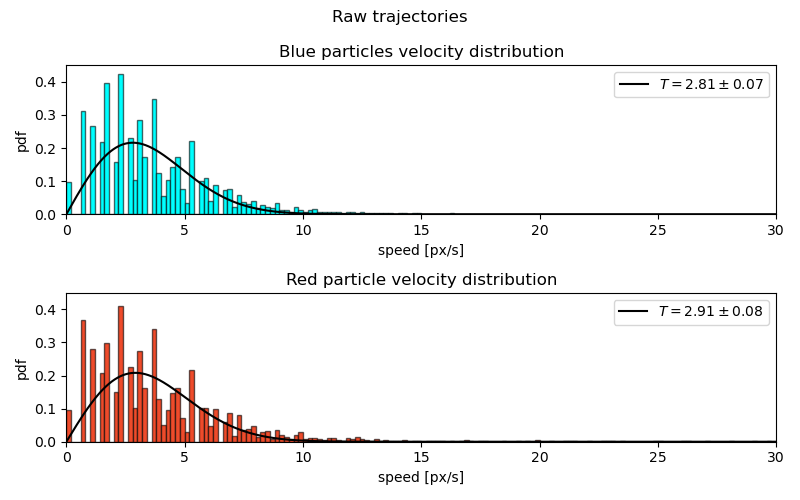

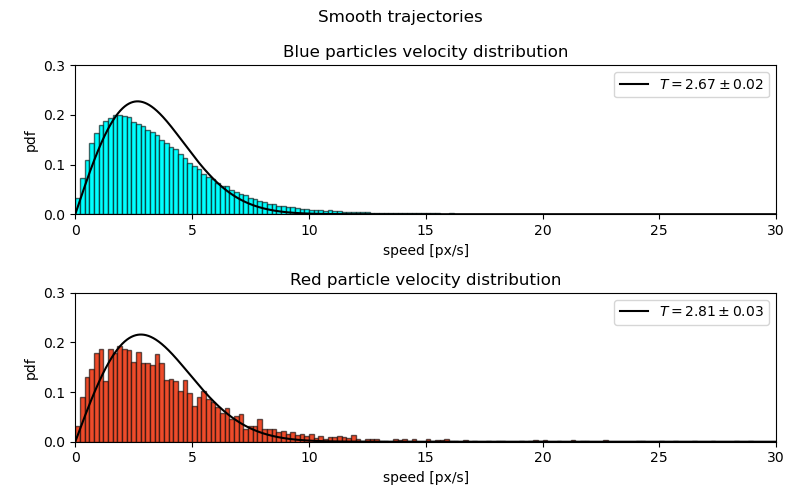


 Windowed speed distribution Analysis


100%|██████████| 291/291 [01:00<00:00,  4.83it/s]


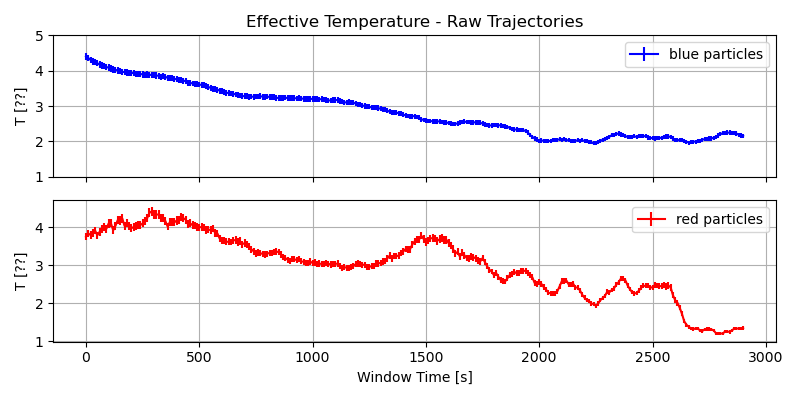

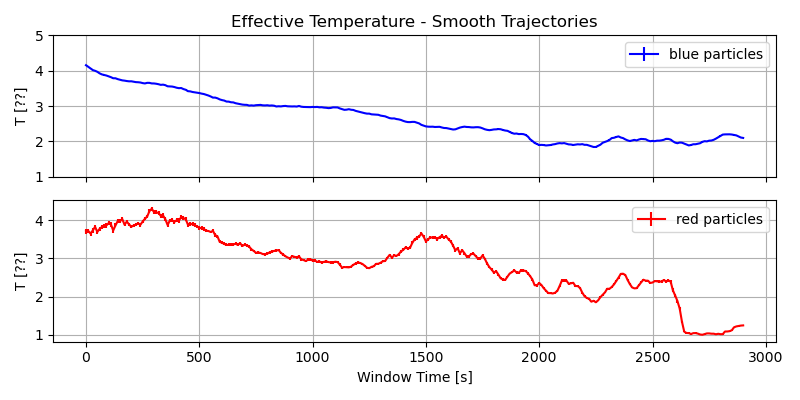

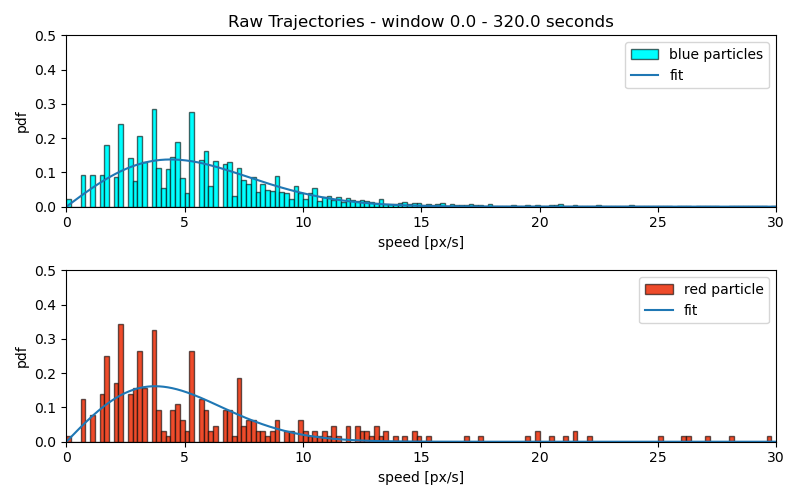

/Users/matteoscandola/miniconda3/envs/pyenv3/lib/python3.10/site-packages/matplotlib/animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


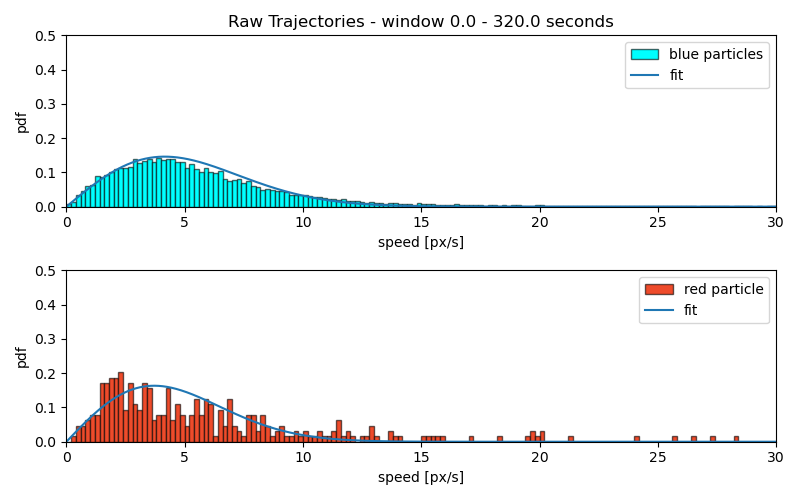

In [5]:
show_verb = True
plot_verb = True
animated_plot_verb = True
save_verb = False

v_step = 10

print(f"Speed Analysis: trajs_verb = {traj_verb}, show_verb = {show_verb}, animated_plot_verb = {animated_plot_verb}")
%run ./analysis_modules/velocity_distr.ipynb

# TURNING ANGLES DISTRIBUTIONS

In [ ]:
show_verb = False
run_windowed_analysis = True
plot_verb = True
animated_plot_verb = True
save_verb = True

# choose the distribution to fit
distribution_str = "lorentzian"

if distribution_str == "gaussian":
    distribution = normal_distr
elif distribution_str == "lorentzian":
    distribution = lorentzian_distr
    distribution_str = "lorentzian"
else:
    raise ValueError("distribution_str must be either 'gaussian' or 'lorentzian'")

print(f"Turning Angles Analysis: trajs_verb = {traj_verb}, show_verb = {show_verb}, animated_plot_verb = {animated_plot_verb}")
%run ./analysis_modules/turning_angles.ipynb

# VELOCITY AUTOCORRELATION

In [7]:
show_verb = False
run_windowed_analysis = False
plot_verb = True
animated_plot_verb = True
save_verb = True

print(f"Velocity Autocorrelation Analysis: show_verb = {show_verb}, run_windowed_analysis = {run_windowed_analysis}, animated_plot_verb = {animated_plot_verb}")
%run ./analysis_modules/velocity_autocorrelation.ipynb

Velocity Autocorrelation Analysis: show_verb = False, run_windowed_analysis = False, animated_plot_verb = True
Global Velocity Autocovariance Function
Windowed analysis


23:39:19 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
23:39:19 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x500 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y ./hough_results/velocity_autocovariance/vacf_wind_raw.mp4
23:39:44 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
23:39:44 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x500 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y ./hough_results/velocity_autocovariance/vacf_wind_smooth.mp4


# RADIAL DISTRIBUTON FUNCTION

In [24]:
nFrames

32000

Radial Distribution Function Analysis: run_analysis_verb = False, show_verb = False, animated_plot_verb = True
RDF - Raw Trajectories
raw
RDF - Smooth Trajectories
smooth


15:41:58 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
15:41:58 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1000x400 -pix_fmt rgba -r 60 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y ./hough_results/radial_distribution_function/rdf_raw.mp4
15:42:55 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
15:42:55 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1000x400 -pix_fmt rgba -r 60 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y ./hough_results/radial_distribution_function/rdf_smooth.mp4


RDF from center - Raw Trajectories
RDF from center - Smooth Trajectories


15:43:51 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
15:43:51 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -r 60 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y ./hough_results/radial_distribution_function/rdf_from_center_raw.mp4


KeyboardInterrupt: 

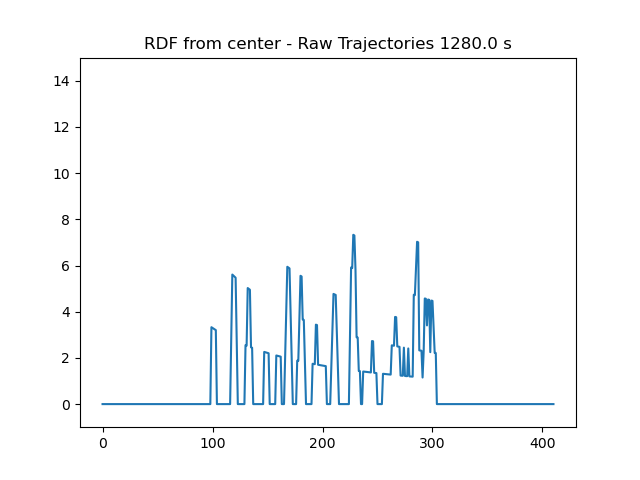

KeyboardInterrupt: 

In [23]:
run_analysis_verb = True
show_verb = False
animated_plot_verb = True
save_verb = True

print(f"Radial Distribution Function Analysis: {traj_verb}, run_analysis_verb = {run_analysis_verb}, show_verb = {show_verb}, animated_plot_verb = {animated_plot_verb}")
%run ./analysis_modules/radial_distribution_function.ipynb

# 3 BODY STRUCTURE METRIC

In [ ]:
run_analysis_verb = False
show_verb = False
animated_plot_verb = False

%run ./analysis_modules/3body_analysis.ipynb